In [1]:
import librosa
import IPython.display as ipd #to visualize the sound data
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pickle

2025-05-25 05:47:39.687031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748152059.885512      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748152059.941894      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[-1.0710210e-08 -5.1222742e-09 -6.5192580e-09 ...  1.8561386e-02
  2.6891200e-02  3.4412310e-02]


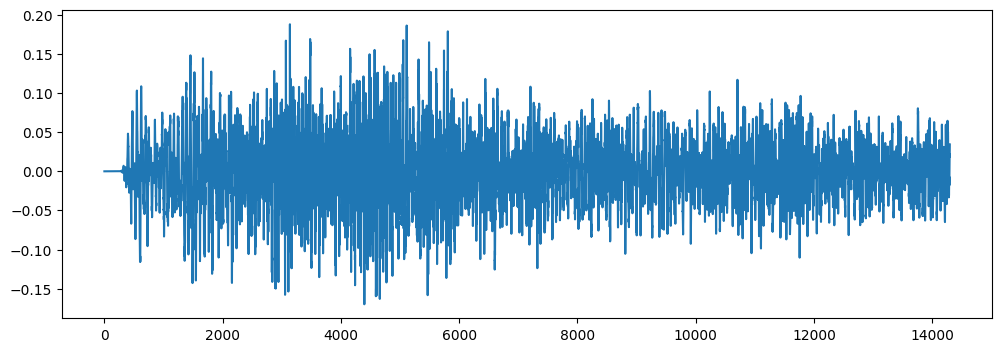

In [2]:
filename='/kaggle/input/urbansound8k/fold10/100648-1-0-0.wav'  # select a random one
data,sample_rate=librosa.load(filename)
ipd.Audio(filename)
librosa_audio_data,librosa_sample_rate=librosa.load(filename)
print(librosa_audio_data)
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [3]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    return mfccs_scaled_features

# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients

audio_dataset_path='/kaggle/input/urbansound8k'
extracted_features=[]
metadata = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    final_class_labels=row["class"]
    
    data=features_extractor(file_name)
    fold = row["fold"]
    extracted_features.append([data, final_class_labels, fold])

    
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class','fold'])
extracted_features_df.head()

3555it [02:07, 27.39it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8322it [04:50, 43.07it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8327it [04:50, 43.87it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [05:03, 28.80it/s]


,feature,class,fold
0,"[-211.93698, 62.581215, -122.81315, -60.745293...",dog_bark,5
1,"[-417.00516, 99.336624, -42.995583, 51.073326,...",children_playing,5
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing,5
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing,5
4,"[-439.63867, 103.86224, -42.658783, 50.690285,...",children_playing,5


In [4]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
folds = np.array(extracted_features_df['fold'].tolist())

In [5]:
labelencoder = LabelEncoder()
extracted_features_df['encoded_label'] = labelencoder.fit_transform(extracted_features_df['class'])

# Then use this column for training:
y = np.array(extracted_features_df['encoded_label'].tolist())

In [6]:
all_histories = []

for fold in range(1, 11):
    print(f"\n Training Fold {fold}")

    train_idx = np.where(folds != fold)
    val_idx = np.where(folds == fold)

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Reshape for LSTM
    X_train = X_train.reshape(-1, 40, 1)
    X_val = X_val.reshape(-1, 40, 1)

    # Model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ModelCheckpoint(f'model_fold{fold}.keras', monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=80,
                        batch_size=32,
                        callbacks=callbacks,
                        verbose=1)
    all_histories.append(history.history)
    score = model.evaluate(X_val, y_val, verbose=0)
    print(f" Fold {fold} Accuracy: {score[1]:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Training Fold 1


I0000 00:00:1748152388.369897      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748152388.370588      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/80


I0000 00:00:1748152393.284406     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2234 - loss: 2.1151 - val_accuracy: 0.3929 - val_loss: 1.7407
Epoch 2/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3940 - loss: 1.6588 - val_accuracy: 0.4513 - val_loss: 1.5756
Epoch 3/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4626 - loss: 1.5137 - val_accuracy: 0.4639 - val_loss: 1.5838
Epoch 4/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5021 - loss: 1.4063 - val_accuracy: 0.5052 - val_loss: 1.4974
Epoch 5/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5347 - loss: 1.2917 - val_accuracy: 0.5223 - val_loss: 1.4092
Epoch 6/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5917 - loss: 1.1953 - val_accuracy: 0.5155 - val_loss: 1.4746
Epoch 7/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5927 - loss: 1.1755 - val_accuracy: 0.5235 - val_loss: 1.4625
Epoch 8/80
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6221 - loss: 1.1081 - val_accuracy: 0.5178 - val_